## IMPORTING LIBRARIRES:

In [2]:
import pandas as pd
import numpy as np
import os
from keras.preprocessing.image import ImageDataGenerator
import tensorflow as tf
from keras.models import Model, Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization, GlobalAveragePooling2D,Activation,Input
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
! pip install seaborn
import seaborn as sns
import cv2

## DATA LOADING:

In [23]:
data_dir=r"D:\project\CODE\data"
acci=[]
for file in os.listdir(data_dir):
    acci+=[file]
print(acci)
print(len(acci))

['Accident', 'No Accident']
2


In [24]:
precision=tf.keras.metrics.Precision()
recall=tf.keras.metrics.Recall()
sensitivity=tf.keras.metrics.SensitivityAtSpecificity(0.1)
specificity=tf.keras.metrics.SpecificityAtSensitivity(0.1)

In [26]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    # Only use the labels that appear in the data
    classes = classes
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

## PREPROCESSING:

In [27]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.image import rgb_to_grayscale
# Define your image dimensions and batch size
img_height = 100  # Replace with your desired image height
img_width = 100   # Replace with your desired image width
batch_size = 32   # Replace with your desired batch size
train_datagen = ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2,
    preprocessing_function=lambda x: rgb_to_grayscale(x)
)
train_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'
)
test_generator = train_datagen.flow_from_directory(
    data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'
)

Found 449 images belonging to 2 classes.
Found 111 images belonging to 2 classes.


## APPLYING DESNET ALGORITHM:

In [28]:
from keras.layers import Input, Conv2D, MaxPooling2D, Dense, GlobalAveragePooling2D, Activation, BatchNormalization, Concatenate
from keras.models import Model
# Define the input shape (img_height, img_width, 3)
input_shape = (img_height, img_width, 3)
# Define the growth rate for the DenseNet
growth_rate = 32
# Define the number of dense blocks and layers per block
num_dense_blocks = 4
num_layers_per_block = [2, 6, 12, 24, 16]  # You can adjust these as needed
# Define the compression factor (reduction factor) for the transition layers
compression = 0.5
# Define the input layer
input_layer = Input(shape=input_shape)
# Initial convolution layer
x = Conv2D(64, (7, 7), strides=(2, 2), padding='same', activation='relu')(input_layer)
x = MaxPooling2D((3, 3), strides=(2, 2), padding='same')(x)
# Dense Blocks
for block in range(num_dense_blocks):
    for layer in range(num_layers_per_block[block]):
        # Batch Normalization
        x = BatchNormalization()(x)
        x = Activation('relu')(x)
        # Convolution
        x = Conv2D(growth_rate, (3, 3), padding='same')(x)
        # Concatenate with previous layers
        if layer > 0:
            concat_layers = [x, prev_x]
            x = Concatenate(axis=-1)(concat_layers)
        prev_x = x
    # Transition layer with compression
    if block < num_dense_blocks - 1:
        num_filters = int(x.shape[-1] * compression)
        x = Conv2D(num_filters, (1, 1), padding='same')(x)
        x = MaxPooling2D((2, 2), strides=(2, 2))(x)
# Global Average Pooling
x = GlobalAveragePooling2D()(x)
# Fully connected (dense) layers
x = Dense(512, activation='relu')(x)
# Output layer
output_layer = Dense(2, activation='softmax')(x)
# Create the DenseNet model
model2 = Model(inputs=input_layer, outputs=output_layer)
# Print a summary of the model architecture
model2.summary()


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_3 (InputLayer)           [(None, 100, 100, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_96 (Conv2D)             (None, 50, 50, 64)   9472        ['input_3[0][0]']                
                                                                                                  
 max_pooling2d_8 (MaxPooling2D)  (None, 25, 25, 64)  0           ['conv2d_96[0][0]']              
                                                                                                  
 batch_normalization_88 (BatchN  (None, 25, 25, 64)  256         ['max_pooling2d_8[0][0]']  

## MODEL TRAINING:

In [30]:

model2.compile(optimizer="adam",loss="categorical_crossentropy",metrics=['accuracy',precision,recall,sensitivity,specificity])
hist2=model2.fit(train_generator,epochs=15,validation_data=test_generator)


Epoch 1/15
15/15 [==============================] - 104s 2s/step - loss: 1.3017 - accuracy: 0.8196 - precision_1: 0.8196 - recall_1: 0.8196 - sensitivity_at_specificity_1: 0.9198 - specificity_at_sensitivity_1: 0.9198 - val_loss: 0.4399 - val_accuracy: 0.9009 - val_precision_1: 0.9009 - val_recall_1: 0.9009 - val_sensitivity_at_specificity_1: 0.9369 - val_specificity_at_sensitivity_1: 0.9369
Epoch 2/15
15/15 [==============================] - 29s 2s/step - loss: 0.3826 - accuracy: 0.8976 - precision_1: 0.8976 - recall_1: 0.8976 - sensitivity_at_specificity_1: 1.0000 - specificity_at_sensitivity_1: 1.0000 - val_loss: 0.5303 - val_accuracy: 0.9009 - val_precision_1: 0.9009 - val_recall_1: 0.9009 - val_sensitivity_at_specificity_1: 1.0000 - val_specificity_at_sensitivity_1: 1.0000
Epoch 3/15
15/15 [==============================] - 31s 2s/step - loss: 0.3614 - accuracy: 0.8976 - precision_1: 0.8976 - recall_1: 0.8976 - sensitivity_at_specificity_1: 1.0000 - specificity_at_sensitivity_1: 1

In [31]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, accuracy_score, confusion_matrix

# Make predictions with your model on the test set
y_pred = model2.predict(test_generator)  # Get raw predictions

# Convert to class predictions (assuming one-hot encoded or probabilities)
y_pred_classes = np.argmax(y_pred, axis=1)  # Get the class with the highest score

# True labels (assume they are part of test_generator)
y_true = test_generator.classes  # Ground truth labels

# Calculate metrics
accuracy = accuracy_score(y_true, y_pred_classes)
precision = precision_score(y_true, y_pred_classes, average='macro')
recall = recall_score(y_true, y_pred_classes, average='macro')

# Compute specificity using confusion matrix
conf_matrix = confusion_matrix(y_true, y_pred_classes)

# Specificity calculation for binary classification
if len(conf_matrix) == 2:
    tn = conf_matrix[0, 0]
    fp = conf_matrix[0, 1]
    specificity = tn / (tn + fp)
else:
    specificity = None  # Specificity isn't well-defined for multi-class scenarios


4/4 [==============================] - 11s 1s/step


In [32]:
import pandas as pd

# Create a DataFrame to represent the classification table
classification_table = pd.DataFrame({
    "Metric": ["Accuracy", "Precision", "Recall", "Specificity"],
    "Value": [accuracy, precision, recall, specificity]
})

# Display the classification table
print(classification_table)


        Metric     Value
0     Accuracy  0.126126
1    Precision  0.550926
2       Recall  0.515000
3  Specificity  1.000000


In [33]:
import tensorflow as tf
from tensorflow.keras import backend as K

# Precision
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

# Recall (Sensitivity)
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

# Specificity
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    specificity = true_negatives / (possible_negatives + K.epsilon())
    return specificity


In [35]:
y_true = test_generator.classes  # Ground truth labels from test generator


In [36]:
y_true = test_generator.classes  # Ground truth labels from test generator


## GRAPH:

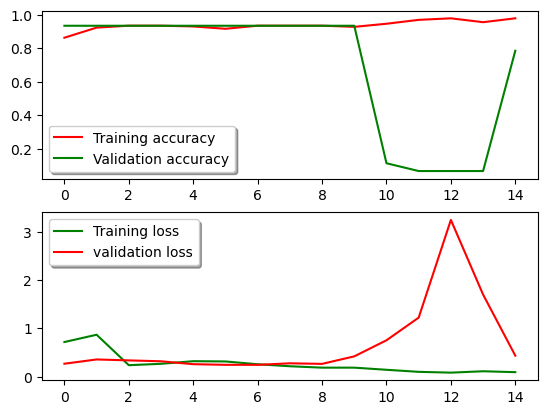

In [16]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist2.history['accuracy'], color='r', label="Training accuracy")
ax[0].plot(hist2.history['val_accuracy'], color='g',label="Validation accuracy")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist2.history['loss'], color='g', label="Training loss")
ax[1].plot(hist2.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

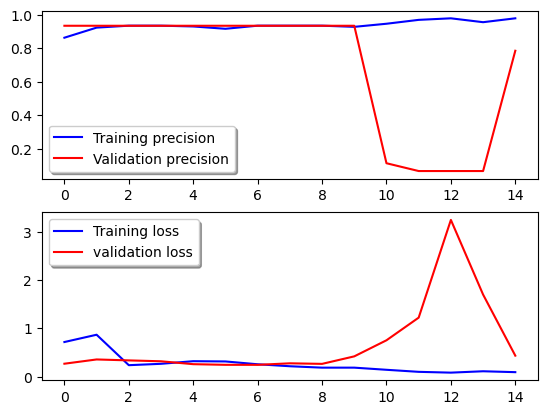

In [17]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist2.history['precision'], color='b', label="Training precision")
ax[0].plot(hist2.history['val_precision'], color='r',label="Validation precision")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist2.history['loss'], color='b', label="Training loss")
ax[1].plot(hist2.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

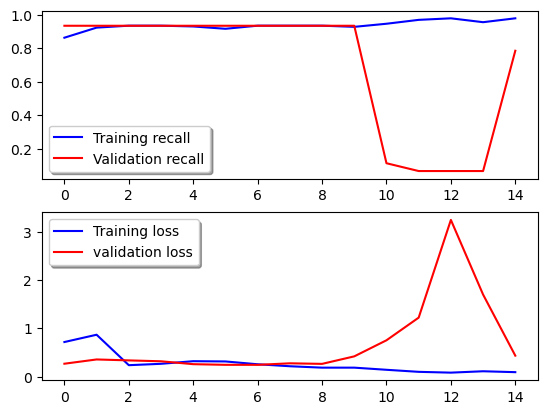

In [18]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist2.history['recall'], color='b', label="Training recall")
ax[0].plot(hist2.history['val_recall'], color='r',label="Validation recall")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist2.history['loss'], color='b', label="Training loss")
ax[1].plot(hist2.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

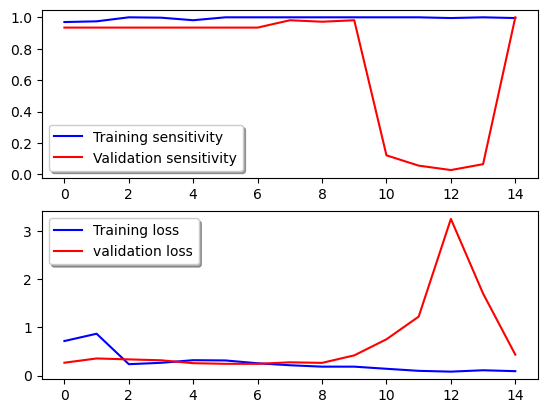

In [19]:
fig, ax = plt.subplots(2,1)
ax[0].plot(hist2.history['sensitivity_at_specificity'], color='b', label="Training sensitivity")
ax[0].plot(hist2.history['val_sensitivity_at_specificity'], color='r',label="Validation sensitivity")
legend = ax[0].legend(loc='best', shadow=True)

ax[1].plot(hist2.history['loss'], color='b', label="Training loss")
ax[1].plot(hist2.history['val_loss'], color='r', label="validation loss")
legend = ax[1].legend(loc='best', shadow=True)

In [37]:
model2.evaluate(test_generator)
model2.save("confusion\desnet.h5")

4/4 [==============================] - 13s 727ms/step - loss: 5.0118 - accuracy: 0.1261 - precision: 0.1271 - recall: 0.1271 - specificity: 0.1271


In [38]:
filenames = test_generator.filenames
nb_samples = len(filenames)
model2_predict = model2.predict_generator(test_generator,steps = nb_samples, verbose=2)

C:\Users\Dr.G.NITHIN-ESWAR\AppData\Local\Temp\ipykernel_24736\723852190.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  model2_predict = model2.predict_generator(test_generator,steps = nb_samples, verbose=2)


111/111 - 9s - 9s/epoch - 79ms/step


Confusion matrix, without normalization
[[11  0]
 [97  3]]


<Axes: title={'center': 'Confusion matrix'}, xlabel='Predicted label', ylabel='True label'>

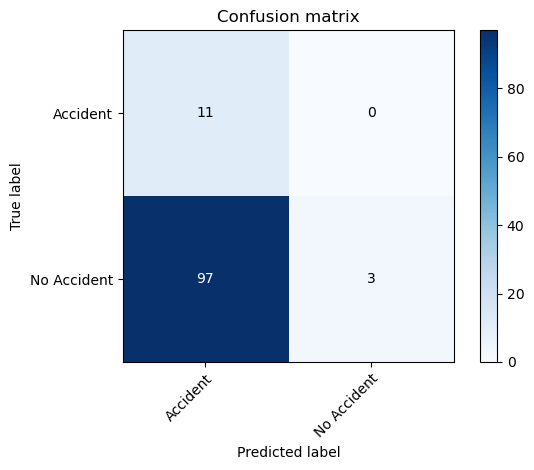

In [39]:
y_true = test_generator.classes
y_pred = model2_predict.argmax(axis=1)
plot_confusion_matrix(y_true, y_pred, classes=['Accident', 'No Accident'],
                      title='Confusion matrix')

In [35]:
from skimage.transform import resize 
from skimage.io import imread 
from sklearn.model_selection import GridSearchCV 
from sklearn.model_selection import train_test_split 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report

In [36]:
#dataframe 
df=pd.DataFrame(flat_data) 
df['Target']=target 
df.shape

(526, 30001)

In [37]:
#input data 
x=df.iloc[:,:-1] 
#output data 
y=df.iloc[:,-1]


In [38]:
# Splitting the data into training and testing sets 
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.20, 
											random_state=77) 

In [43]:
# For multi-class classification, get the class with the highest probability
y_pred_classes = y_pred.argmax(axis=0)  # Find the class with the highest score
y_test_classes = y_test.argmax(axis=0)  # If labels are one-hot encoded


In [49]:
report = classification_report(y_test_classes, y_pred_classes)

# Print the classification report
print(report)

TypeError: Singleton array 0 cannot be considered a valid collection.